
# Evaluation and Resampling


## Week 4 - T


### 2023/2024



## Example 

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
#plt.style.use('seaborn-white')

### Example: Auto dataset 

Compare linear vs higher-order polynomial terms in a linear regression


In [2]:
df1 = pd.read_csv('Auto.csv', na_values='?').dropna()

df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


### Cross-Validation

#### Validation Set Approach 

- We randomly split the 392 observations into two sets: 
  -  training set containing 196 of the data points
  -  validation set containing the remaining 196 observations.
  
Using Polynomial feature generation in scikit-learn<BR>
http://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features

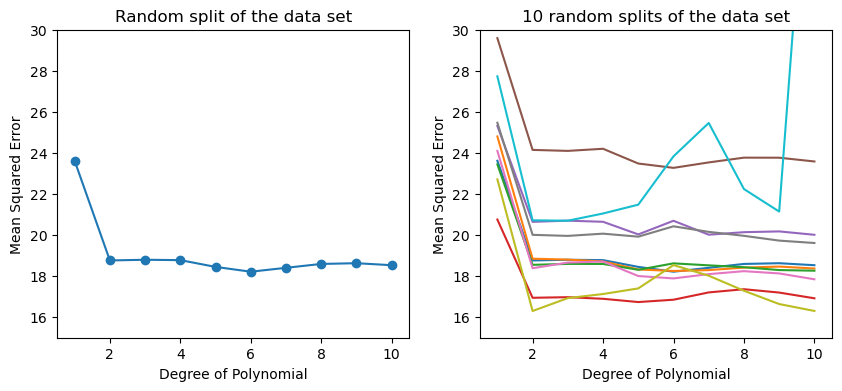

In [4]:
t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

### Leave-One-Out Cross-Validation (LOOC)

- Leave-one-out
    - If the sample is very small we can make $K=N$
    - We train with **all examples but one** in each iteration
    - Leave-one-out still estimates Expected Test Error


In [14]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(df1)
scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, df1.mpg, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score)

In [15]:
# k-fold CV
folds = 10
elements = len(df1.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    
    kf_10 = KFold(n_splits=folds, random_state=Y[i,j], shuffle=True)
    #kf_10 = KFold(n_splits=folds, random_state=None, shuffle=False)
    
    Z[i,j] = cross_val_score(regr, X_poly, df1.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()    
    
   

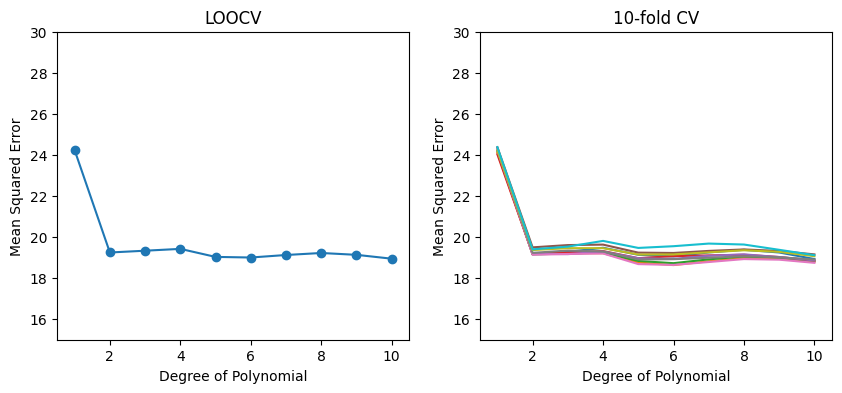

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Note: cross_val_score() method return negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot
ax1.plot(p_order, np.array(scores)*-1, '-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));